In [26]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

#Parameter combinations to test:
    #α=0,    N²=1e-6, M²=1e-6  Control (no strain) 
    #α=1e-6, N²=1e-6, M²=1e-6  Weak strain 
    #α=1e-5, N²=1e-6, M²=1e-6 Moderate strain (paper-like) 
    #α=1e-5, N²=1e-5, M²=1e-6 Strong stratification done
    #α=1e-5, N²=1e-6, M²=1e-5 Weaker front
    #α=1e-5, N²= 0 , M²=1e-6  Zero PV case to compare with ST13
    #α=1e-5, N²= 1e-3 , M²=1e-6  Explodes!
    
    #α=0, N²= 0 , M²=9e-6  B00 case


# File naming convention: filename = "front_α=(α)_N²=(N²)_M²=(M²).nc"
ds = xr.open_dataset('larger_domain2.nc', engine = 'netcdf4', decode_times=False)

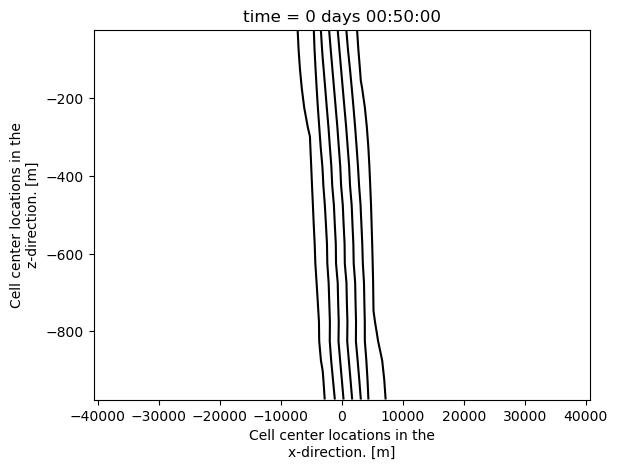

In [24]:
ds.b[5,:,100:140].plot.contour(levels=20, colors='k')

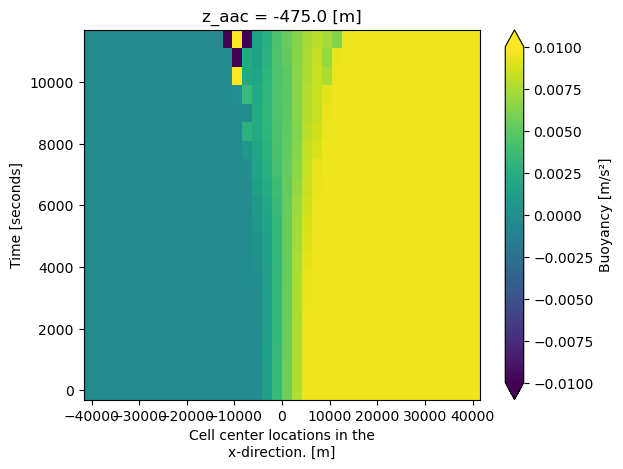

In [31]:
ds.b[:20,10,100:140].plot(vmin = -0.01, vmax = 0.01)

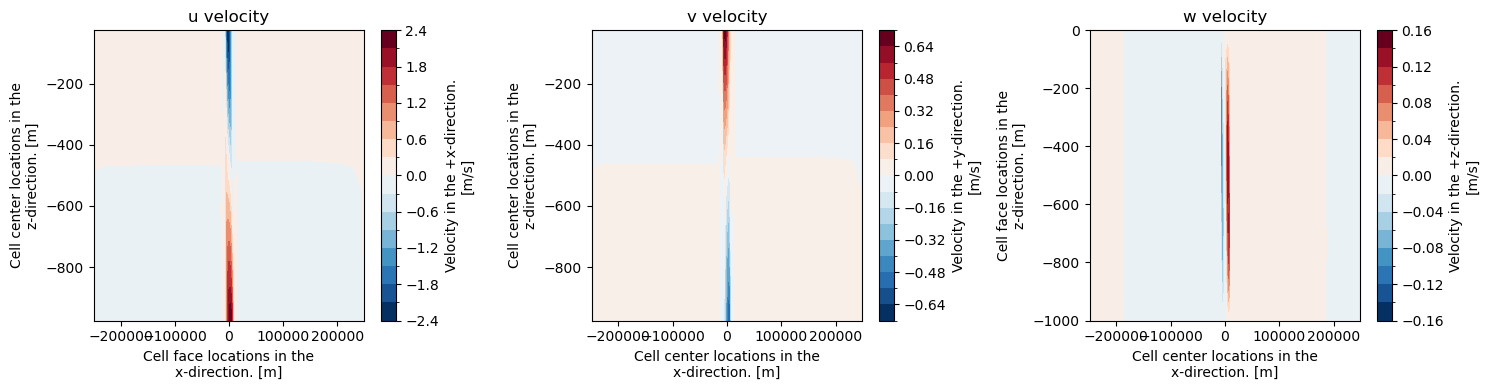

In [19]:

#Velocity components

t= 10

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
ds.u.isel(time=t).plot.contourf(ax=axes[0], levels=20, cmap='RdBu_r')
ds.v.isel(time=t).plot.contourf(ax=axes[1], levels=20, cmap='RdBu_r')
ds.w.isel(time=t).plot.contourf(ax=axes[2], levels=20, cmap='RdBu_r')
axes[0].set_title('u velocity')
axes[1].set_title('v velocity')
axes[2].set_title('w velocity')
plt.tight_layout()
plt.show()

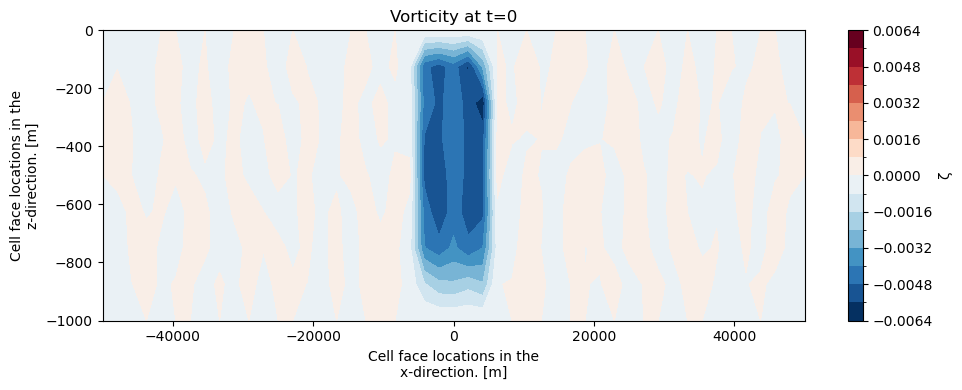

In [ ]:
#Vorticity
fig, ax = plt.subplots(figsize=(10, 4))
ds.ζ.isel(time=t).plot.contourf(levels=20, cmap='RdBu_r', ax=ax)
ax.set_title('Vorticity at t=0')
plt.tight_layout()
plt.show()

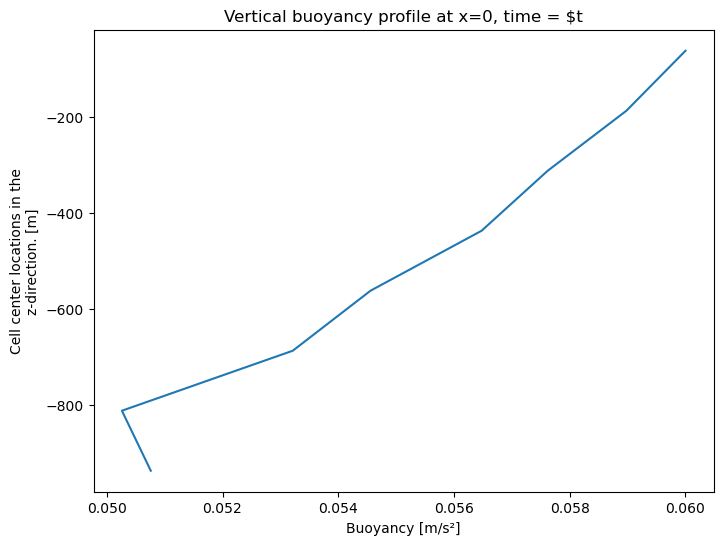

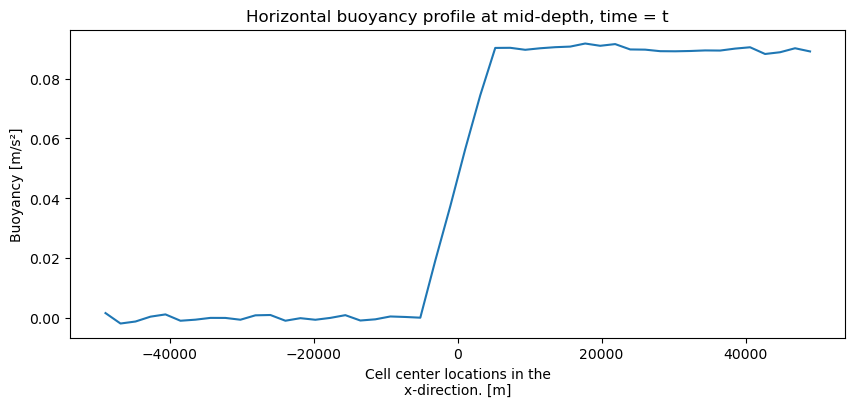

In [ ]:
# Vertical profile at center
fig, ax = plt.subplots(figsize=(8, 6))
ds.b.isel(x_caa=24, time=t).plot(y='z_aac', ax=ax)
ax.set_title('Vertical buoyancy profile at x=0, time = $t')
plt.show()

# Horizontal profile at mid-depth
fig, ax = plt.subplots(figsize=(10, 4))
ds.b.isel(z_aac=4, time=t).plot(x='x_caa', ax=ax)
ax.set_title('Horizontal buoyancy profile at mid-depth, time = t')
plt.show()

c:\Users\Tom Cummings\anaconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:1298: RuntimeWarning: invalid value encountered in multiply
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
c:\Users\Tom Cummings\anaconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:1298: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
c:\Users\Tom Cummings\anaconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:1307: RuntimeWarning: invalid value encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_0
c:\Users\Tom Cummings\anaconda3\Lib\site-packages\numpy\lib\_function_base_impl.py:1314: RuntimeWarning: invalid value encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice2)] - f[tuple(slice3)]) / dx_n


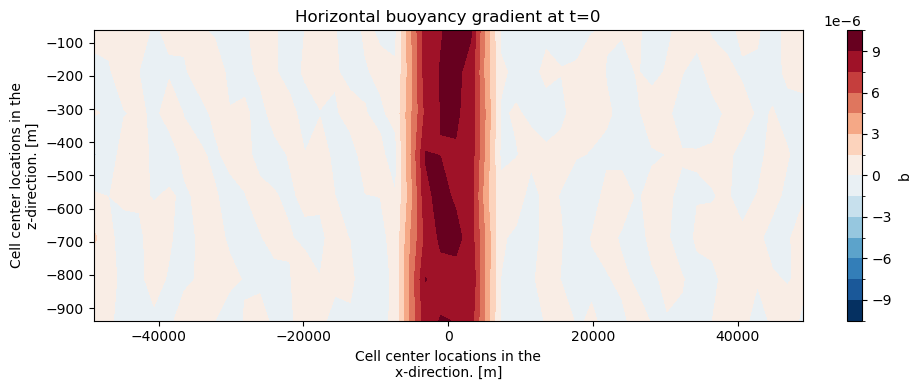

In [ ]:
# Calculate front strength (horizontal buoyancy gradient)
M_squared = ds.b.differentiate('x_caa')

fig, ax = plt.subplots(figsize=(10, 4))
M_squared.isel(time=0).plot.contourf(levels=20, cmap='RdBu_r', ax=ax)
ax.set_title('Horizontal buoyancy gradient at t=0')
plt.tight_layout()
plt.show()

In [ ]:
# For the case with α=0, compare with geostrophic adjustment theory
# Calculate theoretical adjusted state (from Blumen & Wu 1995)
# You'll need to implement equations from the paper here

# For the case with α≠0, compare with Hoskins & Bretherton theory

ValueError: supplied range of [0.0, inf] is not finite

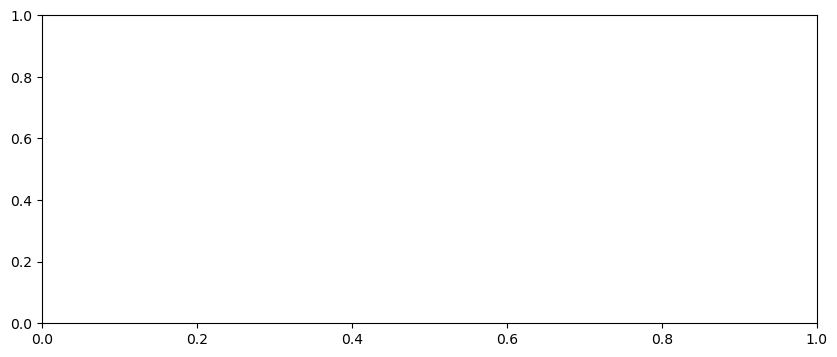

In [ ]:
# Plot kinetic energy over time near boundaries vs center
KE = 0.5 * (ds.u**2 + ds.v**2 + ds.w**2)
KE_boundary = KE.isel(x_caa=0).mean(dim='z_aac')  # Left boundary
KE_center = KE.isel(x_caa=24).mean(dim='z_aac')   # Center

fig, ax = plt.subplots(figsize=(10, 4))
KE_boundary.plot(label='Boundary', ax=ax)
KE_center.plot(label='Center', ax=ax)
ax.set_ylabel('Kinetic Energy')
ax.set_xlabel('Time')
ax.legend()
plt.title("Velocity at edge vs center over time")
plt.tight_layout()
plt.show()

C:\Users\Tom Cummings\AppData\Local\Temp\ipykernel_9336\1632377628.py:2: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds_alpha0 = xr.open_dataset('run_a=0_N^2=1e-6_M^2=1e-6.nc')
C:\Users\Tom Cummings\AppData\Local\Temp\ipykernel_9336\1632377628.py:3: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype

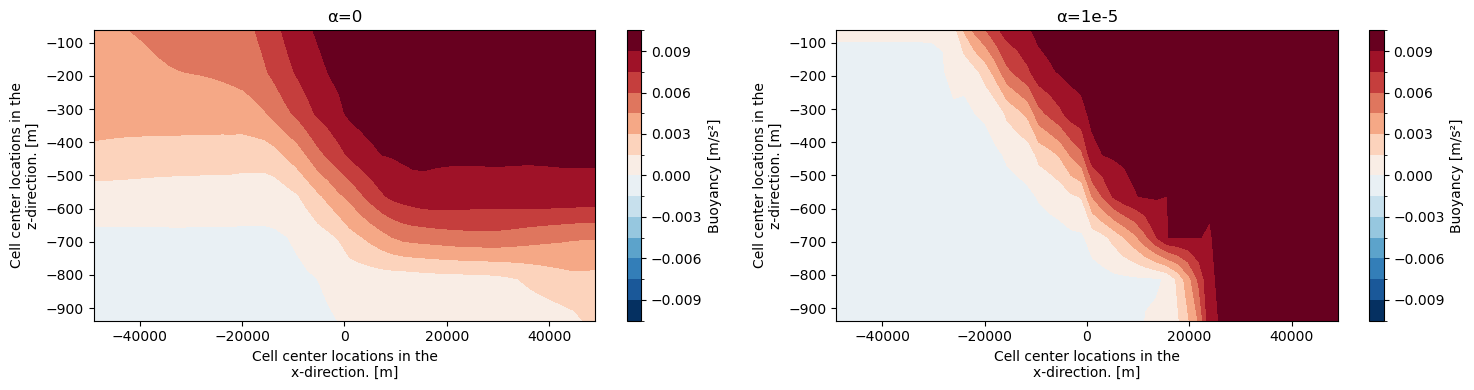

In [ ]:
# Load different datasets
ds_alpha0 = xr.open_dataset('run_a=0_N^2=1e-6_M^2=1e-6.nc')
ds_alpha1e5 = xr.open_dataset('run_a=1e-5_N^2=1e-6_M^2=1e-6.nc')

# Compare buoyancy evolution
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
ds_alpha0.b.isel(time=t).plot.contourf(ax=axes[0], levels=20, cmap='RdBu_r')
ds_alpha1e5.b.isel(time=t).plot.contourf(ax=axes[1], levels=20, cmap='RdBu_r')
axes[0].set_title('α=0')
axes[1].set_title('α=1e-5')
plt.tight_layout()
plt.show()